In [38]:
import pandas,seaborn
import matplotlib, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Patch

In [39]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(8, 5), 'svg.fonttype' : 'none'})

In [40]:
file_directory = "/Users/kja11/OneDrive - Menntaský (1)/Mild_Hypothermia_project/in_silico/Python/"

# II] Data Download

In [42]:
#data all_counts_filtered
df = pandas.read_csv(file_directory+'1) input/RNAseq/transcript_HEK293_temp_all_counts_unfiltered.tsv',
                     sep = '\t')
print(df.shape)
df.head()

(135603, 9)


,gene_id,gene_name,feature_id,s37rep2,s32rep3,s37rep1,s37rep3,s32rep1,s32rep2
0,ENSG00000198034,RPS4X,ENST00000316084,232646,199874,190685,196125,160799,177622
1,ENSG00000142937,RPS8,ENST00000396651,191357,163277,156765,160123,133777,150626
2,ENSG00000182774,RPS17,ENST00000647841,188996,163258,157911,153051,133896,156007
3,ENSG00000229117,RPL41,ENST00000546591,182501,170503,142081,168055,126151,146154
4,ENSG00000142937,RPS8,ENST00000485390,182336,155347,148909,154214,126332,142296


In [43]:
# Import data from hsapiens_gene_ensembl
dataset = pybiomart.Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
annotation = dataset.query(attributes=['external_gene_name', 'external_transcript_name', 'ensembl_gene_id', 'ensembl_transcript_id',
                                       'gene_biotype', 'transcript_biotype', 'description'])

annotation = annotation.rename(columns = {'Gene stable ID' : 'gene_id',
                                   'Transcript stable ID' : 'transcript_id'})

annotation.set_index('transcript_id', drop=True, inplace=True)
# annotation.set_index('Gene stable ID', inplace=True)
annotation.head(2)

,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description
transcript_id,,,,,,
ENST00000387314,MT-TF,MT-TF-201,ENSG00000210049,Mt_tRNA,Mt_tRNA,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
ENST00000389680,MT-RNR1,MT-RNR1-201,ENSG00000211459,Mt_rRNA,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:HGNC ...


# III] Data transformation

In [44]:
# Organize the df
df = df.rename(columns = {'feature_id' : 'transcript_id'})
df.set_index('transcript_id', drop=True, inplace=True)
df = df.drop(['gene_name', 'gene_id'], axis=1)
print(df.head(1))
# It's not the good column order
df = df[['s37rep1', 's37rep2', 's37rep3', 's32rep1', 's32rep2', 's32rep3']]
df.head()

                 s37rep2  s32rep3  s37rep1  s37rep3  s32rep1  s32rep2
transcript_id                                                        
ENST00000316084   232646   199874   190685   196125   160799   177622


,s37rep1,s37rep2,s37rep3,s32rep1,s32rep2,s32rep3
transcript_id,,,,,,
ENST00000316084,190685,232646,196125,160799,177622,199874
ENST00000396651,156765,191357,160123,133777,150626,163277
ENST00000647841,157911,188996,153051,133896,156007,163258
ENST00000546591,142081,182501,168055,126151,146154,170503
ENST00000485390,148909,182336,154214,126332,142296,155347


In [46]:
# Remove the non expressed transcripts (less than 10 counts)
full_leng = len(df)
df = df[df.max(axis=1) >= 10]

filtr_leng = len(df)
dropped_transcripts = full_leng - filtr_leng

print(f'On {full_leng}, {dropped_transcripts} transcripts do not exceed 10 counts')

df

On 135603, 68143 transcripts do not exceed 10 counts


,s37rep1,s37rep2,s37rep3,s32rep1,s32rep2,s32rep3
transcript_id,,,,,,
ENST00000316084,190685,232646,196125,160799,177622,199874
ENST00000396651,156765,191357,160123,133777,150626,163277
ENST00000647841,157911,188996,153051,133896,156007,163258
ENST00000546591,142081,182501,168055,126151,146154,170503
ENST00000485390,148909,182336,154214,126332,142296,155347
...,...,...,...,...,...,...
ENST00000648570,1,0,16,0,1,0
ENST00000395360,0,0,24,0,0,0
ENST00000479866,0,0,12,0,1,0


             PC1           PC2  samples
0  -14394.763909 -86318.400363  s37rep1
1  272191.816781 -60916.111284  s37rep2


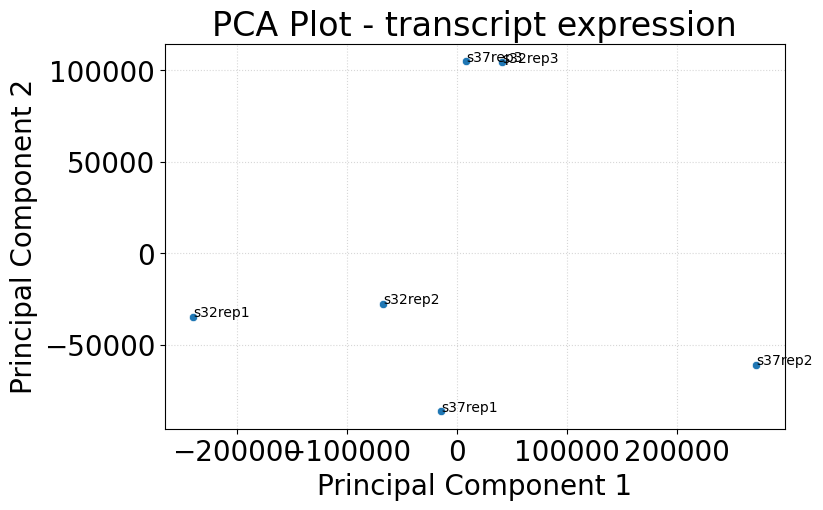

In [47]:
pca = PCA(n_components=2)  # We choose 2 components for 2D plot
principal_components = pca.fit_transform(df.T)
pca_df = pandas.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

pca_df['samples'] = df.columns
print(pca_df.head(2))

seaborn.scatterplot(x='PC1', y='PC2', data=pca_df)

for index, row in pca_df.iterrows():
    plt.annotate(row['samples'], (row['PC1'], row['PC2']),
                fontsize = 10)


plt.title('PCA Plot - transcript expression')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Distribution

In [48]:
# calculate mean
df = df.assign(mean_32C = (df[['s37rep1', 's37rep2', 's37rep3']].mean(axis=1).round(0)),
               mean_37C = (df[['s32rep1', 's32rep2', 's32rep3']].mean(axis=1).round(0))) 

print(len(df))
df.head()

67460


,s37rep1,s37rep2,s37rep3,s32rep1,s32rep2,s32rep3,mean_32C,mean_37C
transcript_id,,,,,,,,
ENST00000316084,190685,232646,196125,160799,177622,199874,206485.0,179432.0
ENST00000396651,156765,191357,160123,133777,150626,163277,169415.0,149227.0
ENST00000647841,157911,188996,153051,133896,156007,163258,166653.0,151054.0
ENST00000546591,142081,182501,168055,126151,146154,170503,164212.0,147603.0
ENST00000485390,148909,182336,154214,126332,142296,155347,161820.0,141325.0


           mean_32C
count  6.746000e+04
mean           -inf
std             NaN
min            -inf
25%    3.807355e+00
50%    5.285402e+00
75%    6.977280e+00
max    1.765568e+01

           mean_37C
count  6.746000e+04
mean           -inf
std             NaN
min            -inf
25%    3.459432e+00
50%    4.906891e+00
75%    6.599913e+00
max    1.745308e+01



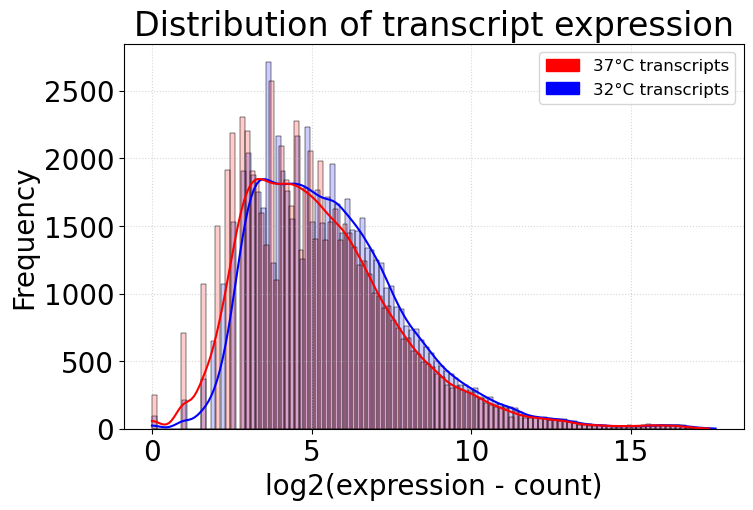

In [50]:
conditions = 'mean_32C', 'mean_37C'
colors = 'blue', 'red'
for i in range(len(conditions)):
    temperature = conditions[i]
    color = colors[i]
    
    df_hist = df[[temperature]].apply(numpy.log2)
    values = df_hist.values.flatten()
    bin_edges = numpy.arange(1, 7.5, 0.5) # Define the bin edges
    hist, edges = numpy.histogram(values, bins=bin_edges) # Calculate the histogram

    print(f'{df_hist.describe()}\n')
    # Create a DataFrame for better visualization
    bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
    count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
#     print(count_df)

    seaborn.histplot(values,color=color, kde=True, alpha=0.2)

    legend_elements = [Patch(facecolor='red', edgecolor='red', label='37°C transcripts'),
                       Patch(facecolor='blue', edgecolor='blue', label='32°C transcripts')]
    
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
    plt.title('Distribution of transcript expression')
    plt.xlabel('log2(expression - count)')
    plt.ylabel('Frequency')